In [1]:
import dask.dataframe as dd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [3]:
%%time
# set data file path
data_file_name = '../data/crimes-2001-to-present.snappy.parq'
print('Loading data file: {}'.format(data_file_name))

# load crimes parquet data into dask df
crimes = dd.read_parquet(data_file_name, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading data file: ../data/crimes-2001-to-present.snappy.parq
Crime data loaded into memory.
Wall time: 14.6 s


In [4]:
%%time
# log records count and load data partitions
print('Chicago Crime data stats:')
print('---------------------------------------')
print('{:,} total records in {} partitions'.format(len(crimes), crimes.npartitions))
print('DataFrame size: {:,}'.format(crimes.size.compute()))

Chicago Crime data stats:
---------------------------------------
6,343,952 total records in 1 partitions
DataFrame size: 50,751,616
Wall time: 4.88 ms


In [5]:
# check data frame structure
crimes

,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
npartitions=1,,,,,,,,
2001-01-01 00:00:00,object,object,object,object,bool,bool,float64,float64
2017-06-15 23:59:00,...,...,...,...,...,...,...,...


In [6]:
%%time
# preview crimes data with Date index
crimes.head(5)

Wall time: 1.95 ms


,Block,PrimaryType,Description,LocationDescription,Arrest,Domestic,Latitude,Longitude
Date,,,,,,,,
2001-09-15 02:00:00,013XX W POLK ST,BATTERY,SIMPLE,STREET,False,False,NaN,NaN
2001-11-02 18:30:00,002XX W CONGRESS PW,THEFT,OVER $500,OTHER,False,False,NaN,NaN
2001-12-15 02:00:00,011XX N STATE ST,BATTERY,SIMPLE,STREET,False,False,NaN,NaN
2002-09-26 13:30:00,034XX W 79TH ST,BATTERY,SIMPLE,STREET,False,False,NaN,NaN
2002-10-01 19:00:00,022XX W NORTH AVE,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,NaN,NaN


In [7]:
%%time

# get crime types
crime_types = crimes[['PrimaryType']]

# get crime counts by primary type
crime_type_total = crime_types.groupby('PrimaryType').size().compute()

# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes[['PrimaryType', 'Arrest', 'Domestic']]\
.groupby('PrimaryType').sum().compute()

# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crime stats (arrests, domestic + total)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                     Arrest  Domestic    Total
PrimaryType                                                   
THEFT                              159868.0   30461.0  1322117
BATTERY                            266032.0  488841.0  1160354
CRIMINAL DAMAGE                     51857.0   54703.0   728750
NARCOTICS                          680928.0     243.0   685180
OTHER OFFENSE                       69425.0  114427.0   393897
ASSAULT                             91871.0   84316.0   389711
BURGLARY                            21240.0    2427.0   369599
MOTOR VEHICLE THEFT                 27588.0    1112.0   298838
ROBBERY                             23472.0    3854.0   240230
DECEPTIVE PRACTICE                  42505.0    2737.0   232990
CRIMINAL TRESPASS                  136053.0    5760.0   183442
PROSTITUTION                        65932.0       6.0    66192
WEAPONS VIOLATION                   50773.0     223.0    63144
PUBLIC PEACE VIOLATION              29407.0    2136.0  

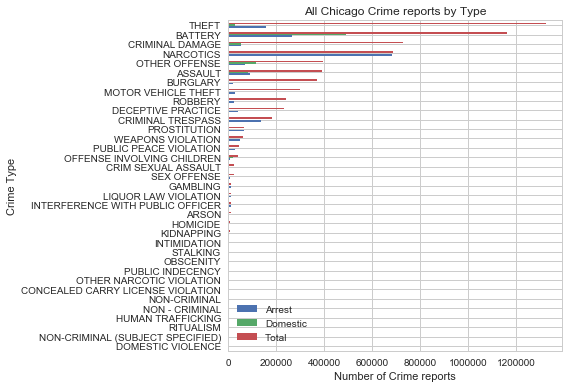

In [8]:
# plot crimes by primary type counts
plt.figure(figsize=(8,10))
crime_type_counts.sort_values(by='Total', ascending=True).plot(kind='barh')

plt.title('All Chicago Crime reports by Type')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crime reports')
plt.tight_layout()
plt.show()

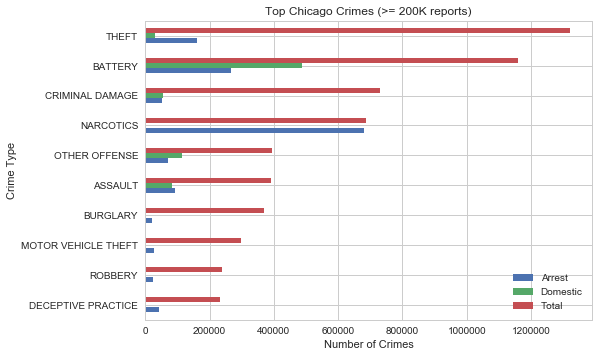

In [9]:
# plot top crimes (>-= 200,000 reports)
crime_type_counts[crime_type_counts['Total'] >= 200000].sort_values(by='Total', ascending=True)\
.plot(kind='barh')

plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.title('Top Chicago Crimes (>= 200K reports)')

In [10]:
# get crime location counts
crime_locations = crimes.groupby('LocationDescription').size().compute()
crime_locations = crime_locations.sort_values(ascending=False).rename('Total') #.reset_index()

# print crime location stats
print(crime_locations.head())
print("...\nTotal Locations: {:,}".format(crime_locations.size))

LocationDescription
STREET       1678131
RESIDENCE    1076137
APARTMENT     648079
SIDEWALK      632697
OTHER         239649
Name: Total, dtype: int64
...
Total Locations: 173


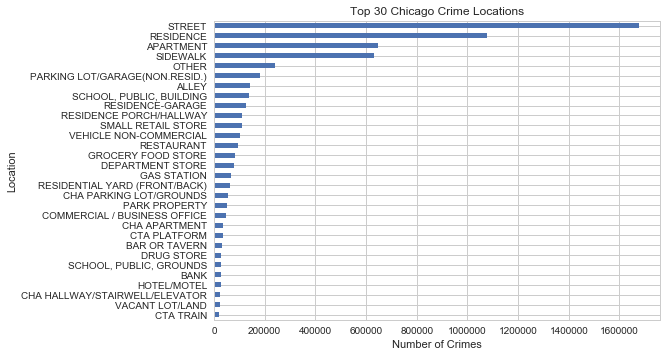

In [11]:
# plot top 30 crime locations
crime_locations[:30].sort_values(ascending=True).plot(kind='barh')

plt.ylabel('Location')
plt.xlabel('Number of Crimes')
plt.title('Top 30 Chicago Crime Locations')

In [12]:
%%time
print('\nParsing All Crimes...')

# get daily total crime counts
daily_crime = crime_types.resample('D').count().compute()

# print daily total crime stats
print('---------------------------------------')
print(daily_crime.head())
print('...\nTotal Crime records: {:,}'.format(len(crimes)))
print('Total Days: {:,}'.format(daily_crime.size))

# get arrests
arrests = crimes[crimes['Arrest'] == True]['Arrest']

# print arrests stats
print('\nArrests:')
print('---------------------------------------')
print(arrests.head())
print("...\nTotal Arrests: {:,}".format(arrests.size.compute()))

# get domestic crimes
domestic = crimes[crimes['Domestic'] == True]['Domestic']

# print domestic crime stats
print('\nDomestic:')
print('---------------------------------------')
print(domestic.head())
print("...\nTotal Domestic: {:,}".format(domestic.size.compute()))


Parsing All Crimes...
---------------------------------------
            PrimaryType
2001-01-01         1772
2001-01-02         1142
2001-01-03         1149
2001-01-04         1163
2001-01-05         1267
...
Total Crime records: 6,343,952
Total Days: 6,010

Arrests:
---------------------------------------
Date
2002-11-05 16:40:00    True
2006-10-17 13:05:00    True
2005-10-01 09:00:00    True
2006-02-23 19:06:20    True
2009-12-08 10:45:00    True
Name: Arrest, dtype: bool
...
Total Arrests: 1,785,096

Domestic:
---------------------------------------
Date
2016-01-26 15:00:00    True
2017-01-09 07:15:00    True
2016-04-04 01:00:00    True
2016-05-28 13:00:00    True
2016-04-12 03:30:00    True
Name: Domestic, dtype: bool
...
Total Domestic: 822,752
Wall time: 6.14 s


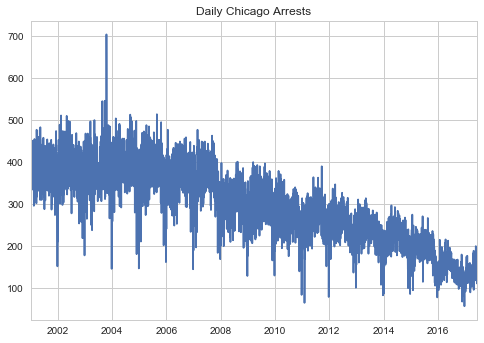

In [15]:
# plot daily arrests
daily_arrests = arrests.resample('D').sum().compute()
daily_arrests.plot()
plt.title('Daily Chicago Arrests')
plt.show()

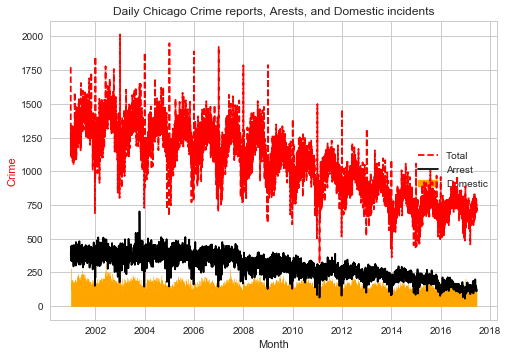

In [16]:
# get daily domestic crimes
daily_domestic = domestic.resample('D').sum().compute()

# plot daily crime counts, arrests, and domestic incidents reports
fig, ax = plt.subplots()
ax.plot(daily_crime.index, daily_crime, '--', label='Total', color='r', zorder=10)
ax.plot(daily_arrests.index, daily_arrests, color='black', zorder=10)
ax.fill_between(daily_domestic.index, daily_domestic, label='Domestic', color='orange')

ax.set_ylabel('Crime', color='r')
ax.set_xlabel('Month')
ax.legend(loc='right')
plt.title('Daily Chicago Crime reports, Arests, and Domestic incidents')
plt.show()

In [27]:
# get top crimes
top_crime_types = crime_type_counts[crime_type_counts['Total'] >= 200000]\
.sort_values(by='Total', ascending=False)
top_crime_types.head(10)

,Arrest,Domestic,Total
PrimaryType,,,
THEFT,159868.0,30461.0,1322117
BATTERY,266032.0,488841.0,1160354
CRIMINAL DAMAGE,51857.0,54703.0,728750
NARCOTICS,680928.0,243.0,685180
OTHER OFFENSE,69425.0,114427.0,393897
ASSAULT,91871.0,84316.0,389711
BURGLARY,21240.0,2427.0,369599
MOTOR VEHICLE THEFT,27588.0,1112.0,298838
ROBBERY,23472.0,3854.0,240230


In [35]:
%%time
print('Getting Top Crimes by Week...')

# get top daily crimes stats
# TODO: use isin and index by primary type to speed up this query?
top_crimes = crime_types[(crime_types['PrimaryType']=='THEFT') | \
                         (crime_types['PrimaryType']=='BATTERY') | \
                         (crime_types['PrimaryType']=='CRIMINAL DAMAGE') | \
                         (crime_types['PrimaryType']=='NARCOTICS') | \
                         (crime_types['PrimaryType']=='OTHER OFFENSE') | \
                         (crime_types['PrimaryType']=='ASSAULT') | \
                         (crime_types['PrimaryType']=='BURGLARY') | \
                         (crime_types['PrimaryType']=='MOTOR VEHICLE THEFT') | \
                         (crime_types['PrimaryType']=='ROBBERY') | \
                         (crime_types['PrimaryType']=='DECEPTIVE PRACTICE')]
#print(top_crimes.head(10))

# group top crimes by week and crime type
crimes_groupby = top_crimes.groupby([pd.TimeGrouper('W'), 'PrimaryType'])
top_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_crime_data.head(10))
print('...')

# unstack top 5 crimes type group for series plotting
top_crime_data = top_crime_data.unstack()
print(top_crime_data.head(10))
print('...')

Getting Top Crimes by Week...
Date        PrimaryType        
2001-01-07  ASSAULT                 467
            BATTERY                1409
            BURGLARY                415
            CRIMINAL DAMAGE        1045
            DECEPTIVE PRACTICE      356
            MOTOR VEHICLE THEFT     504
            NARCOTICS              1052
            OTHER OFFENSE           708
            ROBBERY                 327
            THEFT                  1816
Name: Count, dtype: int64
...
PrimaryType  ASSAULT  BATTERY  BURGLARY  CRIMINAL DAMAGE  DECEPTIVE PRACTICE  \
Date                                                                           
2001-01-07       467     1409       415             1045                 356   
2001-01-14       536     1563       426              884                 297   
2001-01-21       412     1519       437              899                 288   
2001-01-28       469     1408       445              812                 307   
2001-02-04       521     148

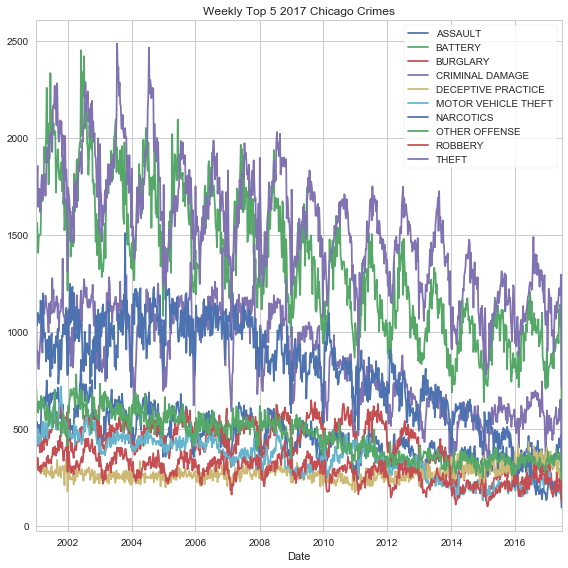

In [36]:
# plot top crimes data by week
top_crime_data.plot(figsize=(8,8))

#plt.xticks([0,1,2,3,4,5,6], calendar.month_name[1:13], rotation=0)
plt.legend(loc='upper right', frameon=True)
plt.title('Top Chicago Crimes by Week')
plt.tight_layout()
plt.show()